In [1]:
import os
import sys
import pprint
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import ParameterGrid
import pprint
from itertools import chain


base_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Modeling.ResultFitter import ResultFitter
from Classes.Modeling.NarrowSearch import NarrowSearch
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
import json

helper = HelperFunctions()
%load_ext tensorboard

In [2]:
### Data conditions: ###
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 0.1,
    'seed' : 1,
    'subsample_size' : 0.05,
    'balance_non_train_set' : True,
    'use_true_test_set' : False
}

loadData = LoadData(**load_args)

full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)
dataGen = DataGenerator(loadData)

if load_args['earth_explo_only']:
    full_and_noise_ds = np.concatenate((full_ds, noise_ds))
    timeAug = TimeAugmentor(handler, full_and_noise_ds, seed = load_args['seed'])
else:
    timeAug = TimeAugmentor(handler, full_ds, seed = load_args['seed'])

Mapping redundancy: [--------------------------------------> ] 98 %

In [3]:
print(len(train_ds), len(val_ds), len(test_ds))
classes, counts = handler.get_class_distribution_from_ds(full_ds)
classes, counts = handler.get_class_distribution_from_ds(train_ds)
classes, counts = handler.get_class_distribution_from_ds(val_ds)
print("Nr noise samples " + str(len(loadData.noise_ds)))

2343 207 207
Total: 2757, earthquake: 923, explosion: 880, noise: 954
Total: 2343, earthquake: 771, explosion: 763, noise: 809
Total: 207, earthquake: 76, explosion: 64, noise: 67
Nr noise samples 809


In [4]:

main_grid = {
            "batch_size" : [64],
            "epochs" : [50],
            "learning_rate" : [0.01],
            "optimizer" : ["sgd"],
            "start_neurons" : [32],
            "dropout_rate" : [0.3],
            "filters" : [17],
            "kernel_size" : [5],
            "padding" : ["same"],
            "l2_r" : [0.001],
            "l1_r" : [0.0001],
            "activation" : ["tanh"],
            "output_layer_activation" : ["sigmoid"]
           }


hyper_grid = {
        "batch_size" : [64, 128, 256, 512],
        "epochs" : [30, 33, 35],
        "learning_rate" : [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "optimizer" : ["adam", "rmsprop", "sgd"]
    }
model_grid = {
    "start_neurons" : [16, 32, 64, 128, 256, 512, 1024],
    "dropout_rate" : [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0],
    "filters" : [11, 13, 15, 17, 19, 21, 23, 25, 27],
    "kernel_size" : [3, 5, 7, 9, 11, 13, 15],
    "padding" : ["same"],
    "l2_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "l1_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "activation" : ["relu", "sigmoid", "softmax", "tanh"],
    "output_layer_activation" : ["sigmoid"]
}


model_nr = 7

use_time_augmentor = True
use_scaler = True
use_noise_augmentor = True
detrend = False
use_minmax = False
use_highpass = False
highpass_freq = 0.1

use_tensorboard = False
use_liveplots = True
use_custom_callback = False
use_early_stopping = True
start_from_scratch = False

narrowSearch = NarrowSearch(loadData, train_ds, val_ds, test_ds, model_nr, detrend, use_scaler, use_time_augmentor, 
                                    use_noise_augmentor, use_minmax, use_highpass, main_grid, hyper_grid, 
                                    model_grid, use_tensorboard = use_tensorboard,use_liveplots = use_liveplots, 
                                    use_custom_callback = use_custom_callback, use_early_stopping = use_early_stopping, 
                                    highpass_freq = highpass_freq, start_from_scratch = start_from_scratch)

2


In [5]:
def clear_tensorboard_dir():
    import os
    import shutil
    path = f"{base_dir}/Tensorboard_dir/fit"
    files = os.listdir(path)
    print(files)
    for f in files:
        shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()
    %tensorboard --logdir tensorboard_dir/fit

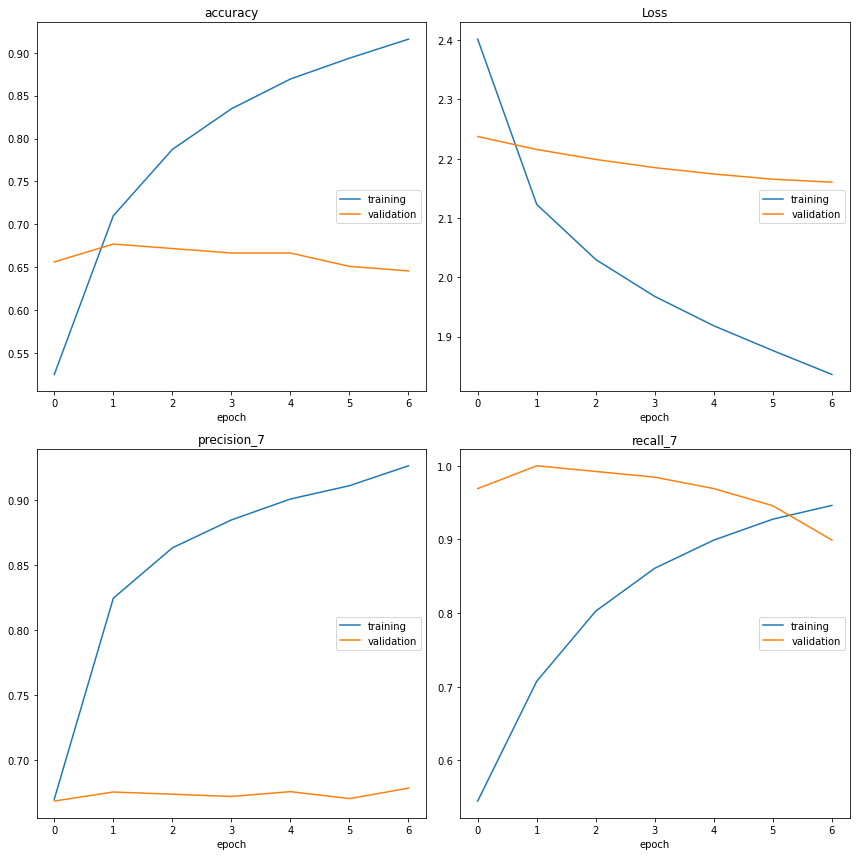

accuracy
	training         	 (min:    0.525, max:    0.916, cur:    0.916)
	validation       	 (min:    0.646, max:    0.677, cur:    0.646)
Loss
	training         	 (min:    1.836, max:    2.402, cur:    1.836)
	validation       	 (min:    2.161, max:    2.238, cur:    2.161)
precision_7
	training         	 (min:    0.670, max:    0.927, cur:    0.927)
	validation       	 (min:    0.668, max:    0.678, cur:    0.678)
recall_7
	training         	 (min:    0.545, max:    0.946, cur:    0.946)
	validation       	 (min:    0.899, max:    1.000, cur:    0.899)
36/36 [==============================] - 7s 182ms/step - loss: 1.8364 - precision_7: 0.9265 - accuracy: 0.9158 - recall_7: 0.9462 - val_loss: 2.1605 - val_precision_7: 0.6784 - val_accuracy: 0.6458 - val_recall_7: 0.8992
Epoch 8/50
24/36 [===================>..........] - ETA: 1s - loss: 1.8059 - precision_7: 0.9374 - accuracy: 0.9258 - recall_7: 0.9504

KeyboardInterrupt: 

In [6]:
results_df, min_loss, max_accuracy, max_precision, max_recall = narrowSearch.fit()

In [ ]:
class NarrowSearch(GridSearchResultProcessor):
    
    def __init__(self, loadData, train_ds, val_ds, test_ds, model_nr_type, detrend, use_scaler, use_time_augmentor, use_noise_augmentor,
                 use_minmax, use_highpass, main_grid, hyper_grid, model_grid, use_tensorboard = False, 
                 use_liveplots = True, use_custom_callback = False, use_early_stopping = False, highpass_freq = 0.1, 
                 start_from_scratch = True):
        
        self.loadData = loadData
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.test_ds = test_ds
        self.model_nr_type = model_nr_type
        self.num_classes = len(set(self.loadData.label_dict.values()))
        self.detrend = detrend
        self.use_scaler = use_scaler
        self.use_noise_augmentor = use_noise_augmentor
        self.use_time_augmentor = use_time_augmentor
        self.use_minmax = use_minmax
        self.use_highpass = use_highpass
        self.main_grid = main_grid
        self.hyper_grid = hyper_grid
        self.model_grid = model_grid
        self.use_tensorboard = use_tensorboard
        self.use_liveplots = use_liveplots
        self.use_custom_callback = use_custom_callback
        self.use_early_stopping = use_early_stopping
        self.highpass_freq = highpass_freq
        self.start_from_scratch = start_from_scratch
        self.helper = HelperFunctions()
        self.dataGen = DataGenerator(self.loadData)
        self.handler = DataHandler(self.loadData)
        if self.loadData.earth_explo_only:
            self.full_ds = np.concatenate((self.loadData.noise_ds, self.loadData.full_ds))
        else:
            self.full_ds = self.loadData.full_ds
        
    def fit(self):
        self.timeAug, self.scaler, self.noiseAug = self.init_preprocessing(self.use_time_augmentor, 
                                                                           self.use_scaler, 
                                                                           self.use_noise_augmentor)
        self.hyper_picks, self.model_picks = self.create_search_space(self.main_grid, self.hyper_grid, self.model_grid)
        self.results_df = self.initiate_results_df(self.results_file_name, self.num_classes, self.start_from_scratch, self.hyper_picks[0], self.model_picks[0])
        for i in range(len(self.hyper_picks)):
            model_info = {"model_nr_type" : self.model_nr_type, "index" : i}
            current_picks = [model_info, self.hyper_picks[i], self.model_picks[i]]
            print(current_picks)
            # Store picked parameters:
            self.results_df = self.store_params_before_fit(current_picks, self.results_df, self.results_file_name)
            
            # Translate picks to a more readable format:
            epoch = self.hyper_picks[i]["epochs"]
            batch_size = self.hyper_picks[i]["batch_size"]
            dropout_rate = self.model_picks[i]["dropout_rate"]
            activation = self.model_picks[i]["activation"]
            output_layer_activation = self.model_picks[i]["output_layer_activation"]
            l2_r = self.model_picks[i]["l2_r"]
            l1_r = self.model_picks[i]["l1_r"]
            start_neurons = self.model_picks[i]["start_neurons"]
            filters = self.model_picks[i]["filters"]
            kernel_size = self.model_picks[i]["kernel_size"]
            padding = self.model_picks[i]["padding"]
            opt = self.helper.getOptimizer(self.hyper_picks[i]["optimizer"], self.hyper_picks[i]["learning_rate"])
            
            # Generate build model args using the picks from above.
            build_model_args = self.helper.generate_build_model_args(self.model_nr_type, batch_size, dropout_rate, 
                                                                     activation, output_layer_activation,
                                                                     l2_r, l1_r, start_neurons, filters, kernel_size, 
                                                                     padding, self.num_classes)
            # Build model using args generated above
            model = Models(**build_model_args).model
            
            # Generate generator args using picks.
            gen_args = self.helper.generate_gen_args(batch_size, self.detrend, use_scaler = self.use_scaler, scaler = self.scaler,
                                                     use_time_augmentor = self.use_time_augmentor, timeAug = self.timeAug, 
                                                     use_noise_augmentor = self.use_noise_augmentor, noiseAug = self.noiseAug,
                                                     use_highpass = self.use_highpass, highpass_freq = self.highpass_freq)
            
            # Initiate generators using the args
            train_gen = self.dataGen.data_generator(self.train_ds, **gen_args)
            val_gen = self.dataGen.data_generator(self.val_ds, **gen_args)
            test_gen = self.dataGen.data_generator(self.test_ds, **gen_args)
            
            # Generate compiler args using picks
            model_compile_args = self.helper.generate_model_compile_args(opt, self.num_classes)
            # Compile model using generated args
            model.compile(**model_compile_args)
            
            print("Starting: ")
            pp.pprint(self.hyper_picks[i])
            print("---------------------------------------------------------------------------------")
            pp.pprint(self.model_picks[i])

            
            # Generate fit args using picks.
            fit_args = self.helper.generate_fit_args(self.train_ds, self.val_ds, batch_size, 
                                                     epoch, val_gen, use_tensorboard = self.use_tensorboard, 
                                                     use_liveplots = self.use_liveplots, 
                                                     use_custom_callback = self.use_custom_callback,
                                                     use_early_stopping = self.use_early_stopping)
            # Fit the model using the generated args
            model_fit = model.fit(train_gen, **fit_args)
            
            # Evaluate the fitted model on the validation set
            loss, accuracy, precision, recall = model.evaluate_generator(generator=val_gen,
                                                                       steps=self.helper.get_steps_per_epoch(self.val_ds, batch_size))
            # Record metrics for train
            metrics = []
            metrics_val = {"val_loss" : loss,
                            "val_accuracy" : accuracy,
                            "val_precision": precision,
                            "val_recall" : recall}
            metrics.append(metrics_val)
            current_picks.append(metrics_val)
            
            # Evaluate the fitted model on the train set
            train_loss, train_accuracy, train_precision, train_recall = model.evaluate_generator(generator=train_gen,
                                                                                        steps=self.helper.get_steps_per_epoch(self.train_ds,
                                                                                                                              batch_size))
            metrics_train = {"train_loss" : train_loss,
                             "train_accuracy" : train_accuracy,
                             "train_precision": train_precision,
                             "train_recall" : train_recall}
            metrics.append(metrics_train)
            current_picks.append(metrics_train)
            self.results_df = self.store_metrics_after_fit(metrics, self.results_df, self.results_file_name)
            
        min_loss, max_accuracy, max_precision, max_recall = self.find_best_performers(self.results_df)
        self.print_best_performers(min_loss, max_accuracy, max_precision, max_recall)
        return self.results_df, min_loss, max_accuracy, max_precision, max_recall
        #return self.results_df

    def print_best_performers(self, min_loss, max_accuracy, max_precision, max_recall):
        print("----------------------------------------------------LOSS----------------------------------------------------------")
        print(f"Min val loss: {min_loss['val_loss']}, at index: {min_loss['val_index']}")
        print(f"Min training loss: {min_loss['train_loss']}, at index: {min_loss['train_index']}")
        print("----------------------------------------------------ACCURACY------------------------------------------------------")
        print(f"Highest val accuracy: {max_accuracy['val_accuracy']}, at index: {max_accuracy['val_index']}")
        print(f"Highest training accuracy: {max_accuracy['train_accuracy']}, at index: {max_accuracy['train_index']}")
        print("----------------------------------------------------PRECISION-----------------------------------------------------")
        print(f"Highest val precision: {max_precision['val_precision']}, at index: {max_precision['val_index']}")
        print(f"Highest training precision: {max_precision['train_precision']}, at index: {max_precision['train_index']}") 
        print("-----------------------------------------------------RECALL-------------------------------------------------------")
        print(f"Highest val recall: {max_recall['val_recall']}, at index: {max_recall['val_index']}")
        print(f"Highest training recall: {max_recall['train_recall']}, at index: {max_recall['train_index']}")
        print("------------------------------------------------------------------------------------------------------------------")
        
        
    def create_search_space(self, main_grid, hyper_grid, model_grid):
        hypermodel_grid = {**hyper_grid, **model_grid}
        key_list = list(hypermodel_grid.keys())
        np.random.shuffle(key_list)
        search_list = []
        for key in key_list:
            if len(hypermodel_grid[key]) > 1:
                one_model = main_grid.copy()
                one_model[key] = hypermodel_grid[key]
                key_grid = list(ParameterGrid(one_model))
                search_list.append(key_grid)
            else:
                continue
        search_list = list(chain.from_iterable(search_list))
        hyper_search, model_search = self.unmerge_search_space(search_list, hyper_grid, model_grid)
        return hyper_search, model_search
    
    def unmerge_search_space(self, search_space, hyper_grid, model_grid):
        hyper_keys = list(hyper_grid.keys())
        model_keys = list(model_grid.keys())
        hyper_search_grid = []
        model_search_grid = []
        for space in search_space:
            hyper_search_grid.append({key:value for (key,value) in space.items() if key in hyper_keys})
            model_search_grid.append({key:value for (key,value) in space.items() if key in model_keys})
        return hyper_search_grid, model_search_grid
    
    def init_preprocessing(self, use_time_augmentor, use_scaler, use_noise_augmentor):
        if use_time_augmentor:
            timeAug = TimeAugmentor(self.handler, self.full_ds, seed = self.loadData.seed)
            timeAug.fit()
        else:
            timeAug = None
        if use_scaler:
            if self.use_minmax:
                scaler = MinMaxScalerFitter(self.train_ds, timeAug).fit_scaler(detrend = self.detrend)
            else:
                scaler = StandardScalerFitter(self.train_ds, timeAug).fit_scaler(detrend = self.detrend)
        else:
            scaler = None
        if use_noise_augmentor:
            noiseAug = NoiseAugmentor(self.loadData.noise_ds, use_scaler, scaler, self.loadData, timeAug)
        else:
            noiseAug = None
        return timeAug, scaler, noiseAug 

In [ ]:
main_grid ={"batch_size" : [64],
            "epochs" : [50],
            "learning_rate" : [0.01],
            "optimizer" : ["sgd"],
            "start_neurons" : [32],
            "dropout_rate" : [0.3],
            "filters" : [17],
            "kernel_size" : [5],
            "padding" : ["same"],
            "l2_r" : [0.001],
            "l1_r" : [0.0001],
            "activation" : ["tanh"],
            "output_layer_activation" : ["sigmoid"]
           }

hyper_grid = {
        "batch_size" : [64, 128, 256, 512],
        "epochs" : [30, 33, 35],
        "learning_rate" : [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "optimizer" : ["adam", "rmsprop", "sgd"]
    }
model_grid = {
    "start_neurons" : [16, 32, 64, 128, 256, 512, 1024],
    "dropout_rate" : [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0],
    "filters" : [11, 13, 15, 17, 19, 21, 23, 25, 27],
    "kernel_size" : [3, 5, 7, 9, 11, 13, 15],
    "padding" : ["same"],
    "l2_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "l1_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "activation" : ["relu", "sigmoid", "softmax", "tanh"],
    "output_layer_activation" : ["sigmoid"]
}

In [ ]:
search_space = create_search_space(main_grid, hyper_grid, model_grid)

In [ ]:
search_space[1]

In [ ]:
def unmerge_search_space(search_space, hyper_grid, model_grid):
        hyper_keys = list(hyper_grid.keys())
        model_keys = list(model_grid.keys())
        hyper_search_grid = []
        model_search_grid = []
        for space in search_space:
            hyper_search_grid.append({key:value for (key,value) in space.items() if key in hyper_keys})
            model_search_grid.append({key:value for (key,value) in space.items() if key in model_keys})
            
        return hyper_search_grid, model_search_grid

In [ ]:
hyper, model = unmerge_search_space(search_space, hyper_grid, model_grid)

In [ ]:
for i in range(len(search_space)):
    assert {**hyper[i], **model[i]} == search_space[i]

In [ ]:
keys = ['a', 'b', 'c']
old ={'a':1,
    'b':2,
    'c':3,
    'd':4}

{(k, old.get(k)) for k in old if k in keys}

In [ ]:
search_space[8]